In [19]:
!pip install MechanicalSoup
!pip install beautifulsoup4

Solving environment: done

# All requested packages already installed.

Requirement already up-to-date: jupyterlab in /home/arnaud/anaconda3/lib/python3.7/site-packages (2.2.9)


An error occured.
ValueError: Please install nodejs >=10.0.0 before continuing. nodejs may be installed using conda or directly from the nodejs website.
See the log file for details:  /tmp/jupyterlab-debug-ot7atqza.log
An error occured.
ValueError: Please install nodejs >=10.0.0 before continuing. nodejs may be installed using conda or directly from the nodejs website.
See the log file for details:  /tmp/jupyterlab-debug-532upbdf.log
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [53]:
import mechanicalsoup
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import math
import random

import re
import io

import matplotlib 
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed
# %matplotlib widget
# functions contained in this ipynb:
'''
get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)
addnoise(data,mu,sigma,typ="gaussian")
sparsify(data,percent)
visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)
c2s(cor)
s2c(cor)
outtxt(cor,outfile)
'''

'\nget_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)\naddnoise(data,mu,sigma,typ="gaussian")\nsparsify(data,percent)\nvisibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)\nc2s(cor)\ns2c(cor)\nouttxt(cor,outfile)\n'

In [54]:
#this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system
def get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular):
#     print("Calling get_data function....")
#     print("this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d")
    planet_to_code = {"sun":"MB:10", "mercury":"MB:199","venus":"MB:299","earth":"MB:399","mars":"MB:499","jupiter":"MB:599",
                  "saturn":"MB:699","uranus":"MB:799","neptune":"MB:899","pluto":"MB:999"}
    observer_to_code={"sun":"@sun","earth":"500"}
    browser = mechanicalsoup.StatefulBrowser()
    url = "https://ssd.jpl.nasa.gov/horizons.cgi"
    browser.open(url)
    browser.follow_link("i?s_type=1")
    browser.select_form()
    if angular and (observer.lower()=="sun" or observer.lower()=="earth"):
        print("error, want angular coordinates but do not specify any observatory or city...")
        exit(1)
    if angular:
        browser["table_type"] = "OBSERVER"
    else:
        browser["table_type"] = "VECTORS"
    response = browser.submit_selected(btnName="set_table_type")
    browser.follow_link("i?s_target=1")
    browser.select_form()
    browser["mb_list"] = "planet"
    response = browser.submit_selected(btnName="show_mb_list")
    browser.select_form()
    browser["body"] = planet_to_code[planet.lower()]
    response = browser.submit_selected(btnName="select_body")
    browser.follow_link("i?s_loc=1")
    if observer.lower()=="sun" or observer.lower()=="earth":
        browser.select_form(nr=0)
        browser["l_str"]=observer_to_code[observer.lower()]
        browser.submit_selected(btnName="s_lookup")
    elif observer.lower()=="observatory":
        browser.select_form(nr=1)
        browser["l_list"]="obs"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        browser["loc_list"] = "399;{};{};".format(observatory[0],observatory[1])
        response = browser.submit_selected()
    elif observer.lower()=="city":
        browser.select_form(nr=1)
        browser["l_list"]="all"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        if "," in city:
            browser["loc_list"] = "399;;{};{}".format(city.split(",")[0].strip(),city.split(",")[1].strip())
        else:
            browser["loc_list"] = "399;;{};".format(city.strip())
        response = browser.submit_selected()
    browser.follow_link("i?s_time=1")
    browser.select_form()
    browser["start_time"] = start
    browser["stop_time"] = end
    browser["interval_mode"] = interval_mode
    browser["step_size"] = step_size
    response = browser.submit_selected(btnName="set_time_span")

    if angular:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        response = browser.submit_selected(btnName="preset_q_table_d")
        form = browser.select_form()
        browser["oq_4"]=1
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
    else:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        form = browser.select_form()
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
        
        
    browser.select_form()
    response = browser.submit_selected()
    s = response.text

    if angular:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Table format.*?:.*?Comma Separated Values.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
#             print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
#         df.rename(columns={ df.columns[1]: "is_sun", 
#                            'Date__(UT)__HR:MN':'time',
#                            'Azi_(a-app)':'az',
#                            'Elev_(a-app)':'el'}, inplace = True)
#         print(df)
        df.rename(columns={ df.columns[1]: "is_sun", }, inplace = True)
        dates = df['Date__(UT)__HR:MN'].to_numpy()
        az = df['Azi_(a-app)'].to_numpy()
        el = df['Elev_(a-app)'].to_numpy()
        is_sun = df['is_sun'].to_numpy()
#         print("data retrieved successfully...")
        return dates, az, el, is_sun
#         return df[['time','is_sun','az','el']].copy()
    
    else:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Reference frame.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
#             print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
        #df.rename(columns={ df.columns[1]: "is_sun" }, inplace = True)
        #print(df)
        date = df["Calendar Date (TDB)"].to_numpy()
        cor = np.vstack((df.X.to_numpy(),df.Y.to_numpy(),df.Z.to_numpy())).T
        vel = np.vstack((df.VX.to_numpy(),df.VY.to_numpy(),df.VZ.to_numpy())).T
        #is_sun = df['is_sun']
#         print("data retrieved successfully...")
        return date,cor,vel

#possible type of noise are gaussian/uniform random noise
def addnoise(data,mu=0,sigma=0.01,typ="gaussian"):
#     print("adding ",typ," noise to data......")
#     print("mu=",mu," and sigma=",sigma)
    ldata=np.copy(data)
    shape=np.shape(ldata)
    ldata=ldata.flatten()
    size=len(ldata)
    if typ=="gaussian":
        ldata+=np.random.normal(mu,sigma,size=size)
    elif typ=="uniform":        
        ldata+=sigma*(np.random.rand(size)-0.5+mu)
    else:
        print("invalid type of noise!")
        print("available types of noise are gaussian or uniform.")
        exit(1)
    return ldata.reshape(shape)

#randomly delete percentage of data assigned by percent
#you may want to do this to sparsify the data due random conditions like weathers, people in charge of observing ask for a day off or so.
def sparsify(data,percent):
    n=len(data)
    ndrawn=int(n*(1-percent))
    print("sparsify ",n,"data into ",n-ndrawn," data...")
    dellist=random.sample(range(n),ndrawn)
    return np.delete(data,dellist,axis=0)

#given cartesian coodinates, convert it to spherical coordinates
def c2s(cor):
    x=cor[:,0]
    y=cor[:,1]
    z=cor[:,2]
    R=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/R)
    phi=np.arctan2(y,x)
    cornew=np.zeros((np.shape(cor)))
    cornew[:,0]=R
    cornew[:,1]=theta
    cornew[:,2]=phi
    return cornew
#given spherical coodinates, convert it to cartesian coordinates, unit au
def s2c(cor):
    r=cor[:,0]
    theta=cor[:,1]
    phi=cor[:,2]
    x=r*np.cos(theta)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.sin(theta)*np.cos(phi)
    cornew[:,0]=x
    cornew[:,1]=y
    cornew[:,2]=z
    return cornew
#save the data in a file
def outtxt(cor,outfile):
    print("writing output to",outfile)
    outfil=open(outfile,"w")
    for i in range(len(cor)):
        outfil.write("{:>24.9E}{:>24.9E}{:>24.9E}\n".format(cor[i,0],cor[i,1],cor[i,2]))
    outfil.close()
    print("done...")
def visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215):
    print("visibledata function: get rid of a data point when planettarget is ahead or behind the sun as observed on planetob so that it shouldn't be visible.")
    date,corta,velta = get_data(planettarget,"sun",observatory,city, start, end, interval_mode, step_size)
    date,corob,velob = get_data(planetob,"sun",observatory,city, start, end, interval_mode, step_size)
    d=np.linalg.norm(np.cross(corta-corob,corob),axis=1)/np.linalg.norm(corta-corob,axis=1)
    idx=np.argwhere(d>Rsun)
    idx=idx.reshape(len(d))
    newdate=[date[i] for i in range(len(date)) if d[i]>Rsun]
    return newdate,corta[idx],velta[idx]   
#get the azimuth and elevation of the sun
def get_data_sun(observer,observatory,city, start, end, interval_mode, step_size):
    return get_data("sun", observer, observatory, city, start, end, interval_mode, step_size, True)

def is_sun_2_vis(is_sun,thresh):
    '''
    Function to determine whether the is_sun designation tells us that we can see the planet.
    
    Input:
        is_sun: numpy array of strings
            Holds arrays containing a string with a single space ' ', 'A', 'N', 'C', or '*'. Meanings below
        thresh:  string
            Sets the is_sun value(s) that constitute the object being visible. This is mean to reflect the fact that
            most celestial bodies are not visible to the naked eye during the day
            Designations below:
            ' ' (string of one space): Night time. Probably not useful, as this will set everything to not visible
            'A' astronautical sunrise/dusk sun is well below horizon, but is lighting up the sky somewhat
                setting this as threshold means any setting greater than or equal this (all that follow) will
                rebder the object invisible
            'N' nautical sunrise/dusk = sun is still below the horizon, but sky is lighting up
            'C' civil sunrise = sun is breaching over the horizon
            '*' daytime using this setting means planets are visisble until daytime
    '''
    if thresh == ' ':
        is_visible = np.zeros(is_sun.shape,dtype=bool)
    elif thresh == 'A':
        is_visible = ~np.isin(is_sun,['A','N','C','*'])
    elif thresh == 'N':
        is_visible = ~np.isin(is_sun,['N','C','*'])
    elif thresh == 'C':
        is_visible = ~np.isin(is_sun,['C','*'])
    else:
        is_visible = ~np.isin(is_sun,['*'])
    
    return is_visible
        
        

In [55]:
def get_venus(start, end, step_size = 1, interval_mode = "h"):
    #time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
    
    #time interval, in unit of interval_mode, currently set as 50 days
    #     step_size = 1

    date,az,el,is_sun = get_data("Venus","city",["K03", "Observatori AAS Montsec"],"Belize City", start, end, interval_mode, step_size, angular=True)
    #get the azimuth and elevation of the sun
#     date_sun, az_sun, el_sun, is_sun_sun = get_data_sun(observer,observatory,city, start, end, interval_mode, step_size)
    #plot out the trajectory of Venus and Sun on the sky viewed on Earth
    #elevation should be bigger than zero --- above the horizon
#     import pdb; pdb.set_trace()
    az_n = addnoise(az)
    el_n = addnoise(el)
    flag = el>0
    #shouldn't be blinded by the sun light
    flag_sun = is_sun_2_vis(is_sun,'*')
    #print(is_sun)
    #print(flag_sun)
    #get rid of the data under the horizon
    az_good = az[flag]
    el_good = el[flag]
    az_good_2 = az[flag & flag_sun]
    el_good_2 = el[flag & flag_sun]
    az_good_n = az_n[flag]
    el_good_n = el_n[flag]
    az_good_2_n = az_n[flag & flag_sun]
    el_good_2_n = el_n[flag & flag_sun]
    time = np.arange(0, step_size*len(az), step_size)
    time_good = time[flag]
    time_good_2 = time[flag & flag_sun]
    return az,el,time,az_good,el_good,time_good,az_good_2,el_good_2,time_good_2,az_n,el_n,az_good_n,el_good_n,az_good_2_n,el_good_2_n
    

In [56]:
az,el,time,az_good,el_good,time_good,az_good_2,el_good_2,time_good_2,az_n,el_n,az_good_n,el_good_n,az_good_2_n,el_good_2_n = get_venus("BC 500-Oct-13","BC 480-Oct-14", 2)


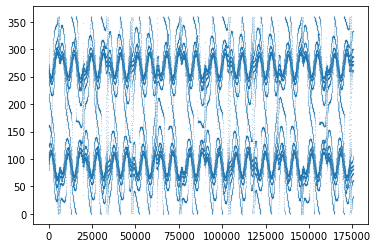

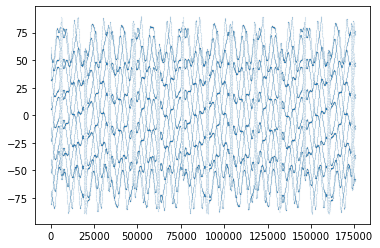

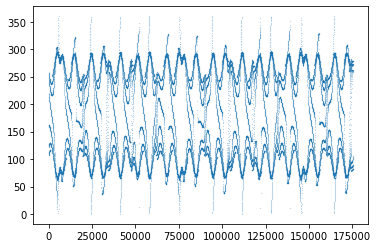

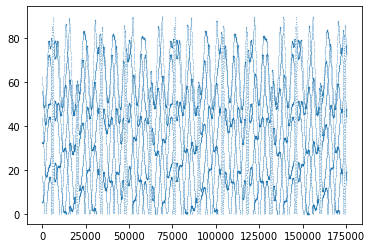

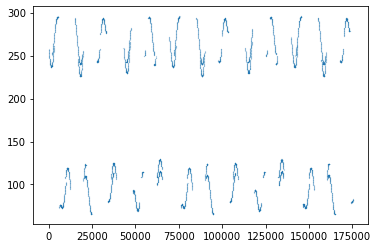

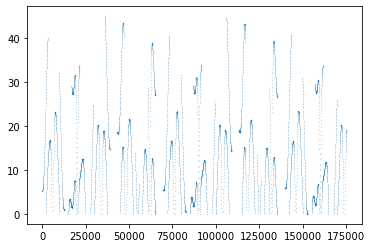

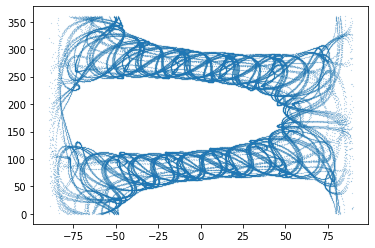

In [39]:
plt.scatter(time,az,s=0.01)
plt.show()
plt.scatter(time,el,s=0.001)
plt.show()
plt.scatter(time_good,az_good,s=0.01)
plt.show()
plt.scatter(time_good,el_good,s=0.01)
plt.show()
plt.scatter(time_good_2,az_good_2,s=0.01)
plt.show()
plt.scatter(time_good_2,el_good_2,s=0.01)
plt.show()
plt.scatter(el,az,s=0.01)
plt.show()


In [66]:
def featurize_fourier(x, d, normalize = False):
    assert (d-1) % 2 == 0, "d must be odd"
    max_r = int((d-1)/2)
    n = len(x)
    A = np.zeros((n, d))
    A[:,0] = 1
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] =  np.sin(d_*x*np.pi)
        A[:,2*(d_-1)+2] =  np.cos(d_*x*np.pi)
    
    if normalize:
        A[:,0] *= (1/np.sqrt(2))
        A *= np.sqrt(2)
        
#     import pdb;pdb.set_trace()
    return A

def plot_fourier_features(x_type,d): 
    n = 128  
    d_max = 21
    np.random.seed(7)
    x_true = generate_x(x_type = 'grid', n=1000)
    x_train = generate_x(x_type=x_type, n=n)
    phi_train = featurize_fourier(x_train, d_max)
    phi_true = featurize_fourier(x_true, d_max)
    
    plt.plot(x_true, phi_true[:,d], linewidth = 0.5)
    plt.scatter(x_train, phi_train[:,d], marker='o')
    plt.ylim([-1.2,1.2])
    plt.xlabel('x')
    plt.ylabel('$\phi(x)$')
    plt.show()
    
from numpy.polynomial.polynomial import polyvander
def featurize_vandermonde(x, d, normalize = False):
    A = polyvander(x, d-1)
    for d_ in range(A.shape[1]):
        if normalize:
            A[:,d_] *=  np.sqrt(2*d_+1)
    return A

def featurize(x, d, phi_type, normalize = False):
    function_map = {'polynomial':featurize_vandermonde, 'fourier':featurize_fourier}
    return function_map[phi_type](x,d,normalize)

from sklearn.linear_model import LinearRegression
def solve_ls(phi, y):
    
    LR = LinearRegression(fit_intercept=False, normalize=False)

#     LR.fit(TODO)
#     coeffs = TODO
    LR.fit(phi, y)
    coeffs = LR.coef_
    
    loss = np.mean((y- phi@coeffs)**2)
    return coeffs, loss

from sklearn.linear_model import Ridge

def solve_ridge(phi, y, lambda_ridge=0):
    
    Rdg = Ridge(fit_intercept=False, normalize=False, alpha = lambda_ridge)

#     Rdg.fit(TODO)
#     coeffs = TODO
    Rdg.fit(phi, y)
    coeffs = Rdg.coef_

    loss = np.mean((y- phi@coeffs)**2) + np.mean(coeffs**2)
    return coeffs, loss

def get_plot_data( phi_type, d, w, n_plot = 1000):
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n_plot)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
#     import pdb; pdb.set_trace()
#     x_plot= generate_x(x_type = 'grid', n=n_plot)
#     y_plot_true = generate_y(x=x_plot)
    phi_plot = featurize(x_trains, d, phi_type)
    
    return x_trains, y_trains, phi_plot @ w

def gen_and_solve(n, d, x_type, phi_type, seed = 1, awgn_std = 0, lambda_ridge = 0):
    np.random.seed(seed)
    
#     x_train = generate_x(x_type=x_type, n=n)
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
    
    phi_train = featurize(x_trains, d, phi_type)
#     y_train = generate_y(x=x_train)
    
    if awgn_std != 0:
        y_trains = add_awgn_noise(y_trains, awgn_std)
        
    if lambda_ridge == 0:
        w, loss = solve_ls(phi_train, y_trains)

    else:
        w, loss = solve_ridge(phi_train, y_trains, lambda_ridge)


    return x_trains, y_trains, w, loss

def visualize_(x_train, y_train,  phi_type, d, w, loss, n_plot = 1000, n_fit = 1000):
    x_plot, y_plot_true, y_plot_pred = get_plot_data( phi_type, d, w, n_plot)
    plt.plot(x_plot, y_plot_true, label = 'True function')
    plt.scatter(x_train, y_train, marker='o', s=20, label = 'Training samples')
    plt.plot(x_plot, y_plot_pred, 'o-', ms=2, label = 'Learned function')

    plt.title("Train loss:" + str("{:.2e}".format(loss)))
#     plt.ylim([-1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor = (1.03, 0.97))
    plt.show()
        
    markerlines, stemlines,  baseline = plt.stem(np.arange(d), w, 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.xlabel('feature #(k)')
    plt.ylabel('weight')
    plt.show()

def plot_true_and_predicted(n, n_plot, n_fit, x_type, phi_type, seed, awgn_std, lambda_ridge, d): 
    x_train, y_train, w, loss = gen_and_solve(n, d, x_type,  phi_type, awgn_std = awgn_std, lambda_ridge = lambda_ridge, seed = seed)
    fit_mse = visualize_(x_train, y_train,  phi_type, d, w, loss, n_plot , n_fit)   

def get_params2():
    n = 64
    n_plot = 1000
    n_fit = 10000
    x_type = 'uniform_random'
    seed = 1
    awgn_std = 0
    lambda_ridge = 0
    return n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge

n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge = get_params2()

slider3 = widgets.IntSlider(
    value=1,
    min=1,
    max=65,
    step=2,
    description='d:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
slider4 = widgets.IntSlider(
    value=65,
    min=65,
    max=1000,
    step=2,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

phi_type = 'fourier'
print("Fourier features")

interactive_plot =interactive(plot_true_and_predicted, n = slider4, n_plot = fixed(n_plot), n_fit = fixed(n_fit), 
                              x_type = fixed(x_type), phi_type = fixed(phi_type),seed = fixed(seed),
                              awgn_std= fixed(awgn_std), lambda_ridge = fixed(lambda_ridge), d = slider3)
interactive_plot

Fourier features


interactive(children=(IntSlider(value=65, continuous_update=False, description='n:', max=1000, min=65, step=2)…